In [79]:
## Auxiliary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import salem
from pathlib import Path
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split

# OGGM
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

cfg.initialize(logging_level='WARNING') # initialize OGGM
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 

2023-04-20 13:48:58: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-20 13:48:58: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-20 13:48:58: oggm.cfg: Multiprocessing: using all available processors (N=4)
2023-04-20 13:48:58: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2023-04-20 13:48:58: oggm.cfg: Multiprocessing switched ON after user settings.


In [107]:
ds_full = pd.read_csv('Data/df_distributed_subset.csv')
ds_full = ds_full[ds_full['glacier_mask']!=0]

In [108]:
# Select RGI_IDs and split the dataset into specified random train and test sets based on the Glacier ID

rgi_ids = np.unique(ds_full.RGI_ID)
glacier_train, glacier_test = train_test_split(rgi_ids, train_size=0.8, test_size=0.2)

ds_train = ds_full[ds_full['RGI_ID'].isin(glacier_train)]
ds_test = ds_full[ds_full['RGI_ID'].isin(glacier_test)]

In [116]:
features_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'RGI_ID', 'glacier_mask','hugonnet_dhdt']

ds_train_X = ds_train.drop(features_to_drop, axis=1)
ds_train_y = ds_train['hugonnet_dhdt']

X_train, Y_train = ds_train_X.values, ds_train_y.values

In [139]:
ds_test_X = ds_test.drop(features_to_drop, axis=1)
ds_test_y = ds_test['hugonnet_dhdt']

X_test, Y_test = ds_test_X.values, ds_test_y.values

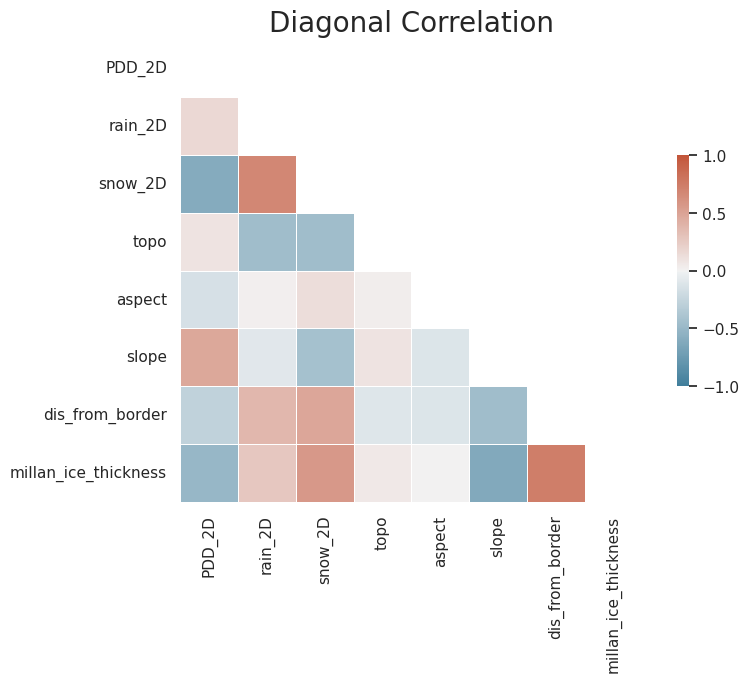

In [117]:
sns.set_theme(style= "white")
# Compute the correlation matrix
corr = ds_train_X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))
plt.title("Diagonal Correlation", fontsize=20);
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [136]:
def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled dhdt (m.w.e)', fontsize=16)
    plt.xlabel('Reference dhdt (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2.5
    lineEnd = 1.5
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

In [125]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [142]:
## Model : Gradient Boost

In [130]:
#model = 'random forest'
model = 'gradient boosting'

params = {
    "n_estimators": [200],
    "max_depth": [4],
    "min_samples_split": [2],
    "learning_rate": [0.1],
    "loss": ['huber'], #"squared_error",
    "validation_fraction": [0.2]
}

reg_ensemble = ensemble.GradientBoostingRegressor(**params)

In [131]:
gb = GridSearchCV(reg_ensemble, params)
gb.fit(X_train, Y_train.ravel())

GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=[0.1],
                                                 loss=['huber'], max_depth=[4],
                                                 min_samples_split=[2],
                                                 n_estimators=[200],
                                                 validation_fraction=[0.2]),
             param_grid={'learning_rate': [0.1], 'loss': ['huber'],
                         'max_depth': [4], 'min_samples_split': [2],
                         'n_estimators': [200], 'validation_fraction': [0.2]})

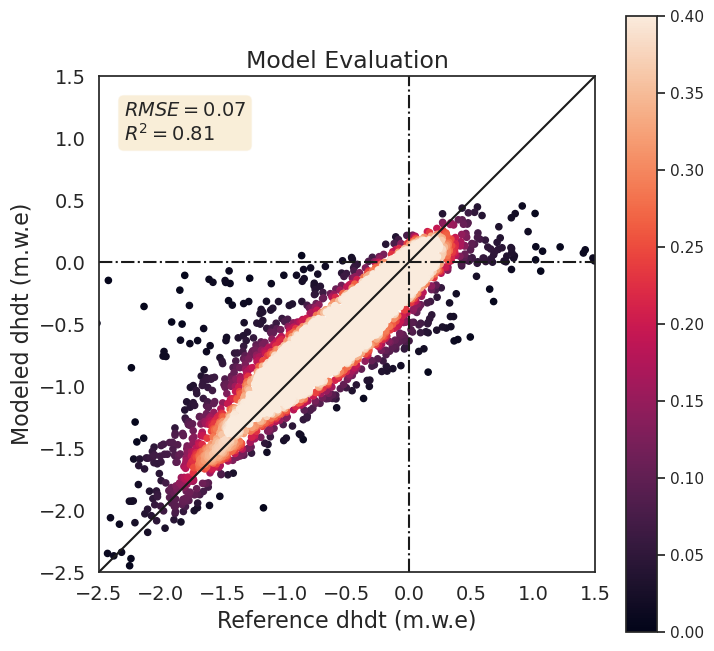

In [137]:
plot_prediction(Y_train, gb.predict(X_train), n_toplot=5000)

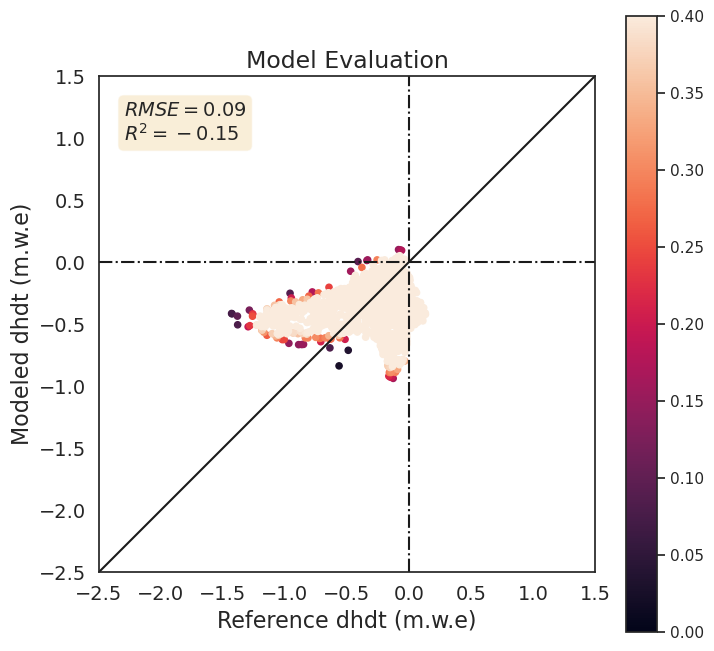

In [140]:
plot_prediction(Y_test, gb.predict(X_test), n_toplot=5000)

array(['RGI60-08.00005', 'RGI60-08.00006', 'RGI60-08.00007',
       'RGI60-08.00008', 'RGI60-08.00009', 'RGI60-08.00010',
       'RGI60-08.00011', 'RGI60-08.00012', 'RGI60-08.00013',
       'RGI60-08.00014'], dtype=object)